In [57]:
### Carregando as bibliotecas 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score,confusion_matrix


In [58]:
### Dicionário dos dados
'''
gender: genero
age: idade
hyptertension: hipertensão (Binário)
heart_disease: doença cardiáca
ever_married: Se o paciente já foi casado
work_type: Tipo de trabalho de um paciente. 
Residence_type: tipo de residência 
avg_glucose_level: nível médio de glicose no sangue. 
bmi: imc
smoking_status: Se já fumou, fuma ou nunca fumou
stroke: se já teve AVC (Binário)
'''

## Objetivo:
'''
Objetivo: Prever a ocorrência de AVC (Stroke)
'''

'\nObjetivo: Prever a ocorrência de AVC (Stroke)\n'

In [59]:
### Abrindo o dataframe
colunas = ['gender','age','hypertension','heart_disease','work_type','Residence_type','avg_glucose_level','bmi','smoking_status','stroke']

df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv', sep = ',' , usecols= colunas)
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Self-employed,Rural,174.12,24.0,never smoked,1


In [60]:
###############################################################################################################################################################################################

In [61]:
### Análise exploratória dos dados e pré processamento. 

## Verificar se as variáveis são correlacionadas entre si. 
matriz_correlacao = df.corr()
matriz_correlacao
# Observamos que as variáveis não são correlacionadas, assim evitanto o problema de multicolinearidade


<ipython-input-61-f6d630920272>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacao = df.corr()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


In [62]:
## Verificando o tamanho do dataset. 
len(df)
# 5110 linhas

5110

In [63]:
## Verificando se existem dados faltantes
df.isnull().sum()
# Existem 201 dados faltantes na coluna bmi (IMC)

# Como 201 dados são poucos na comparando com o número de registro, apenas irei remove-lós sem utilizar técnicas de imputação de dados: 
df = df.dropna()


In [64]:
## Convertento as variáveis discretas em uma representação numérica

mapeamento_genero= {'Male': 1, 'Female': 0, 'Other': 99}
mapeamento_work = {'Private':0 , 'Self-employed':1, 'Govt_job':2, 'children':3, 'Never_worked':4}
mapeamento_Residence = {'Urban': 1 , 'Rural': 0}
mapeamento_smok = {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}

df['gender'] = df['gender'].map(mapeamento_genero)
df['work_type'] = df['work_type'].map(mapeamento_work)
df['Residence_type'] = df['Residence_type'].map(mapeamento_Residence)
df['smoking_status'] = df['smoking_status'].map(mapeamento_smok)

In [65]:
## Observamos que as variáveis age, avg_glucose_level e bmi possuem escalas bem diferentes, então, vão ser normalizadas. 

colunas = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
df[colunas] = scaler.fit_transform(df[colunas])

In [66]:
## Verificando se a variavel target está balanceada
contagem = df['stroke'].value_counts()
contagem 

# A variável target não está balanceada, será necessário utilizar alguma técnica de balanceamento para evitarmos problemas devido a esse desbalanceamento.

0    4700
1     209
Name: stroke, dtype: int64

In [67]:
## Irei utilizar como teste duas técnicas de balancamento, Undersampling e a técnica do ajuste de pesos, com o objetivo de ver qual possui a melhor perfomance. 

# Undersampling

contagem_classes = df['stroke'].value_counts()
min_observacoes = contagem_classes.min()
df_1 = df.groupby('stroke').apply(lambda x: x.sample(min_observacoes)).reset_index(drop=True)

# A juste dos pesos

weights = class_weight.compute_class_weight('balanced', classes=sorted(df['stroke'].unique()), y=df['stroke'])
class_weights = {i: weights[i] for i in range(len(weights))}
df_2 = pd.concat([df[df['stroke'] == classe].sample(frac=class_weights[classe], replace=True) for classe in df['stroke'].unique()])
df_2.reset_index(drop=True, inplace=True)


In [68]:
###############################################################################################################################################################################################

In [69]:
### Construção dos modelos de regressão logística

In [71]:
## Modelo sem balanceamento:

df['intercept'] = 1

model = sm.Logit(df['stroke'], df[['intercept', 'gender','age','hypertension','heart_disease','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']])
result = model.fit()

# Obtendo o resumo da regressão logística
summary = result.summary()
print(summary)

# Através do summary, observamos que as variáveis gender, Residence_type, bmi e smoking_status são quase insiginificantes no modelo.
df = df.drop(['gender', 'Residence_type', 'bmi', 'smoking_status'], axis=1)

Optimization terminated successfully.
         Current function value: 0.139772
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4909
Model:                          Logit   Df Residuals:                     4899
Method:                           MLE   Df Model:                            9
Date:                Sat, 13 May 2023   Pseudo R-squ.:                  0.2060
Time:                        23:23:52   Log-Likelihood:                -686.14
converged:                       True   LL-Null:                       -864.19
Covariance Type:            nonrobust   LLR p-value:                 3.109e-71
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -4.1586      0.216    -19.266      0.000      -4.582      -3.736
gender  

In [75]:
## Undersampling 
df_1['intercept'] = 1

model = sm.Logit(df_1['stroke'], df_1[['intercept', 'gender','age','hypertension','heart_disease','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']])
result = model.fit()

# Obtendo o resumo da regressão logística
summary = result.summary()
print(summary)

# No modelo balanceado por undersampling, temos que as variáveis gender, work_type, Residence_type, bmi, smoking_status  não se mostram significantes.   
df_1= df_1.drop(['gender', 'Residence_type', 'bmi', 'smoking_status'], axis=1)                     

Optimization terminated successfully.
         Current function value: 0.466612
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                  418
Model:                          Logit   Df Residuals:                      408
Method:                           MLE   Df Model:                            9
Date:                Sat, 13 May 2023   Pseudo R-squ.:                  0.3268
Time:                        23:28:37   Log-Likelihood:                -195.04
converged:                       True   LL-Null:                       -289.74
Covariance Type:            nonrobust   LLR p-value:                 5.539e-36
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.3251      0.326     -4.061      0.000      -1.965      -0.686
gender  

In [78]:
## Ajuste por peso
df_2['intercept'] = 1

model = sm.Logit(df_2['stroke'], df_2[['intercept', 'gender','age','hypertension','heart_disease','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']])
result = model.fit()

# Obtendo o resumo da regressão logística
summary = result.summary()
print(summary)

# No modelo balanceado por peso, temos que as variáveis smoking_status,bmi e gender não mostram significância
df_2= df_2.drop(['gender', 'bmi', 'smoking_status'], axis=1)                     

Optimization terminated successfully.
         Current function value: 0.468284
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4908
Model:                          Logit   Df Residuals:                     4898
Method:                           MLE   Df Model:                            9
Date:                Sat, 13 May 2023   Pseudo R-squ.:                  0.3244
Time:                        23:31:28   Log-Likelihood:                -2298.3
converged:                       True   LL-Null:                       -3402.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.2333      0.097    -12.757      0.000      -1.423      -1.044
gender  

In [81]:
### Avaliando a acurácia dos modelos e matriz de confusão dos modelos. 


In [90]:


## Modelo sem balanceamento
X = df.drop(['stroke'], axis=1)
y = df['stroke'] # Variável target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = LogisticRegression()
model.fit(X, y)

predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)
print("Acurácia:", accuracy)

matriz_confusao = confusion_matrix(y, predictions)
matriz_confusao

# Embora, este modelo sejá muito bom na sua acurrácia, ele praticamente errada todas as classificações sobre quem vai ter um AVC, sendo a sua maioria esmagadora falsos negativos. 
# Logo, esse modelo será excluído de cara. 

Acurácia: 0.9576288449786107


array([[4700,    0],
       [ 208,    1]])

Acurácia: 0.7583732057416268
[[153  56]
 [ 45 164]]
Sensibilidade: 0.784688995215311


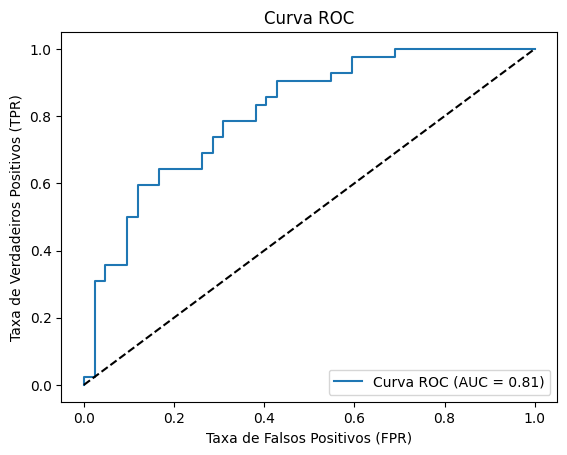

In [104]:
## Modelo por Undersampling 

X = df_1.drop(['stroke'], axis=1)
y = df_1['stroke'] # Variável target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X, y)

predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)
print("Acurácia:", accuracy)

matriz_confusao = confusion_matrix(y, predictions)
print(matriz_confusao)

# Embora, este modelo tenha menos acurácia, sua ele possui verdadeiros positivos (o anterior não) e ainda possui uma boa taxa de verdadeiros negativos. 
# Logo, esse modelo continuara na análise

# Sensibilidade, taxas verdadeiros positivos



# Calculando a sensibilidade:  taxas verdadeiros positivos
# Extraindo os valores da matriz de confusão


TP = matriz_confusao[1, 1]
FN = matriz_confusao[1, 0]

sensibilidade = TP / (TP + FN)
print('Sensibilidade:' , sensibilidade)

# Não irei utilizar especifidade, em um modelo que se deseja prever a ocorrência de um AVC, o que mais vale de fato é a taxas de verdadeiros positivos. 

# Curva ROC 

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal para referência
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# O modelo possui uma boa curva ROC 
# Sendo a área da sua curva 0.81, ou seja, o modelo tem uma boa discriminação

Acurácia: 0.7687449062754687
[[1827  627]
 [ 508 1946]]
Sensibilidade: 0.7929910350448248


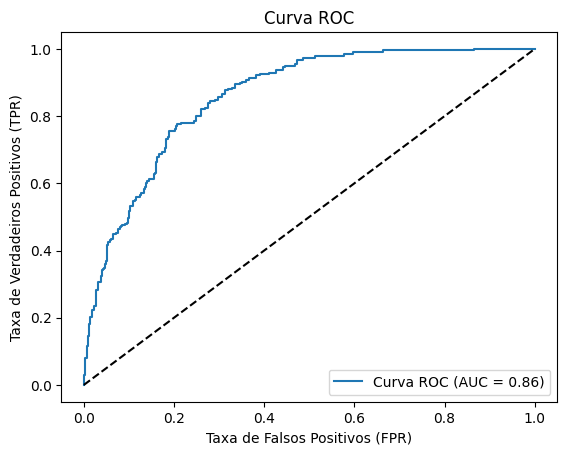

In [105]:
## Modelo por ajuste dos pesos 

X = df_2.drop(['stroke'], axis=1)
y = df_2['stroke'] # Variável target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X, y)

predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)
print("Acurácia:", accuracy)

matriz_confusao = confusion_matrix(y, predictions)
print(matriz_confusao)

# Sensibilidade, taxas verdadeiros positivos
# Extraindo os valores da matriz de confusão
TP = matriz_confusao[1, 1]
FN = matriz_confusao[1, 0]

sensibilidade = TP / (TP + FN)
print('Sensibilidade:' , sensibilidade)

# Não irei utilizar especifidade, em um modelo que se deseja prever a ocorrência de um AVC, o que mais vale de fato é a taxas de verdadeiros positivos. 

# Curva ROC 

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal para referência
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# O modelo possui uma excelente curva roc, comparado ao modelo anterior, ele possui uma curva ROC mais para cima, tendo sua área sobre a curva ainda maior. 

# Portando o modelo a ser escolhido será o modelo em que o balanceamento foi realizado pelo ajuste dos pesos. 
# Pois possui melhor acurácia, melhor sensibilidade e melhor curva ROC
